In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets import SineDataset, SineCosineDataset, CosineDataset
from tiny.utils import plot_point_cloud, plot_point_clouds, count_parameters
from tiny import Diffusion, PointCloudDDPM, PointCloudDiffusionTrainer, UnconditionalPointCloudDiT

In [3]:
# dataset = SineCosineDataset(num_points=32, size=1024)
dataset = SineDataset(num_points=32, size=1024)
# dataset = CosineDataset(num_points=128, size=1024)
dataloader = DataLoader(dataset, collate_fn=dataset.collate, batch_size=128)

In [4]:
diffusion = Diffusion(schedule_type="linear", num_timesteps=1000, learn_sigma=False)
dit = UnconditionalPointCloudDiT(input_size=32, in_channels=2, depth=2, num_heads=1, hidden_size=128)
# dit = MLP(hidden_size=128, hidden_layers=10, emb_size=128).to("cuda")
ddpm = PointCloudDDPM(dit, diffusion)

In [5]:
count_parameters(dit)

678018

In [7]:
trainer = PointCloudDiffusionTrainer(
    ddpm,
    dataloader,
    num_epochs=500,
    lr=1e-3
)

[INFO] Model Parameters: 678018


  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [00:25<00:00, 154.61it/s, loss=0.217]


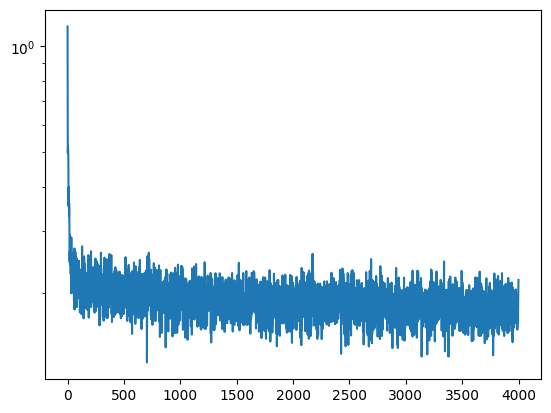

In [8]:
losses = trainer.train()
plt.semilogy(losses)

Sampling:   5%|▍         | 46/1000 [00:00<00:02, 456.85it/s]

Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 623.06it/s]


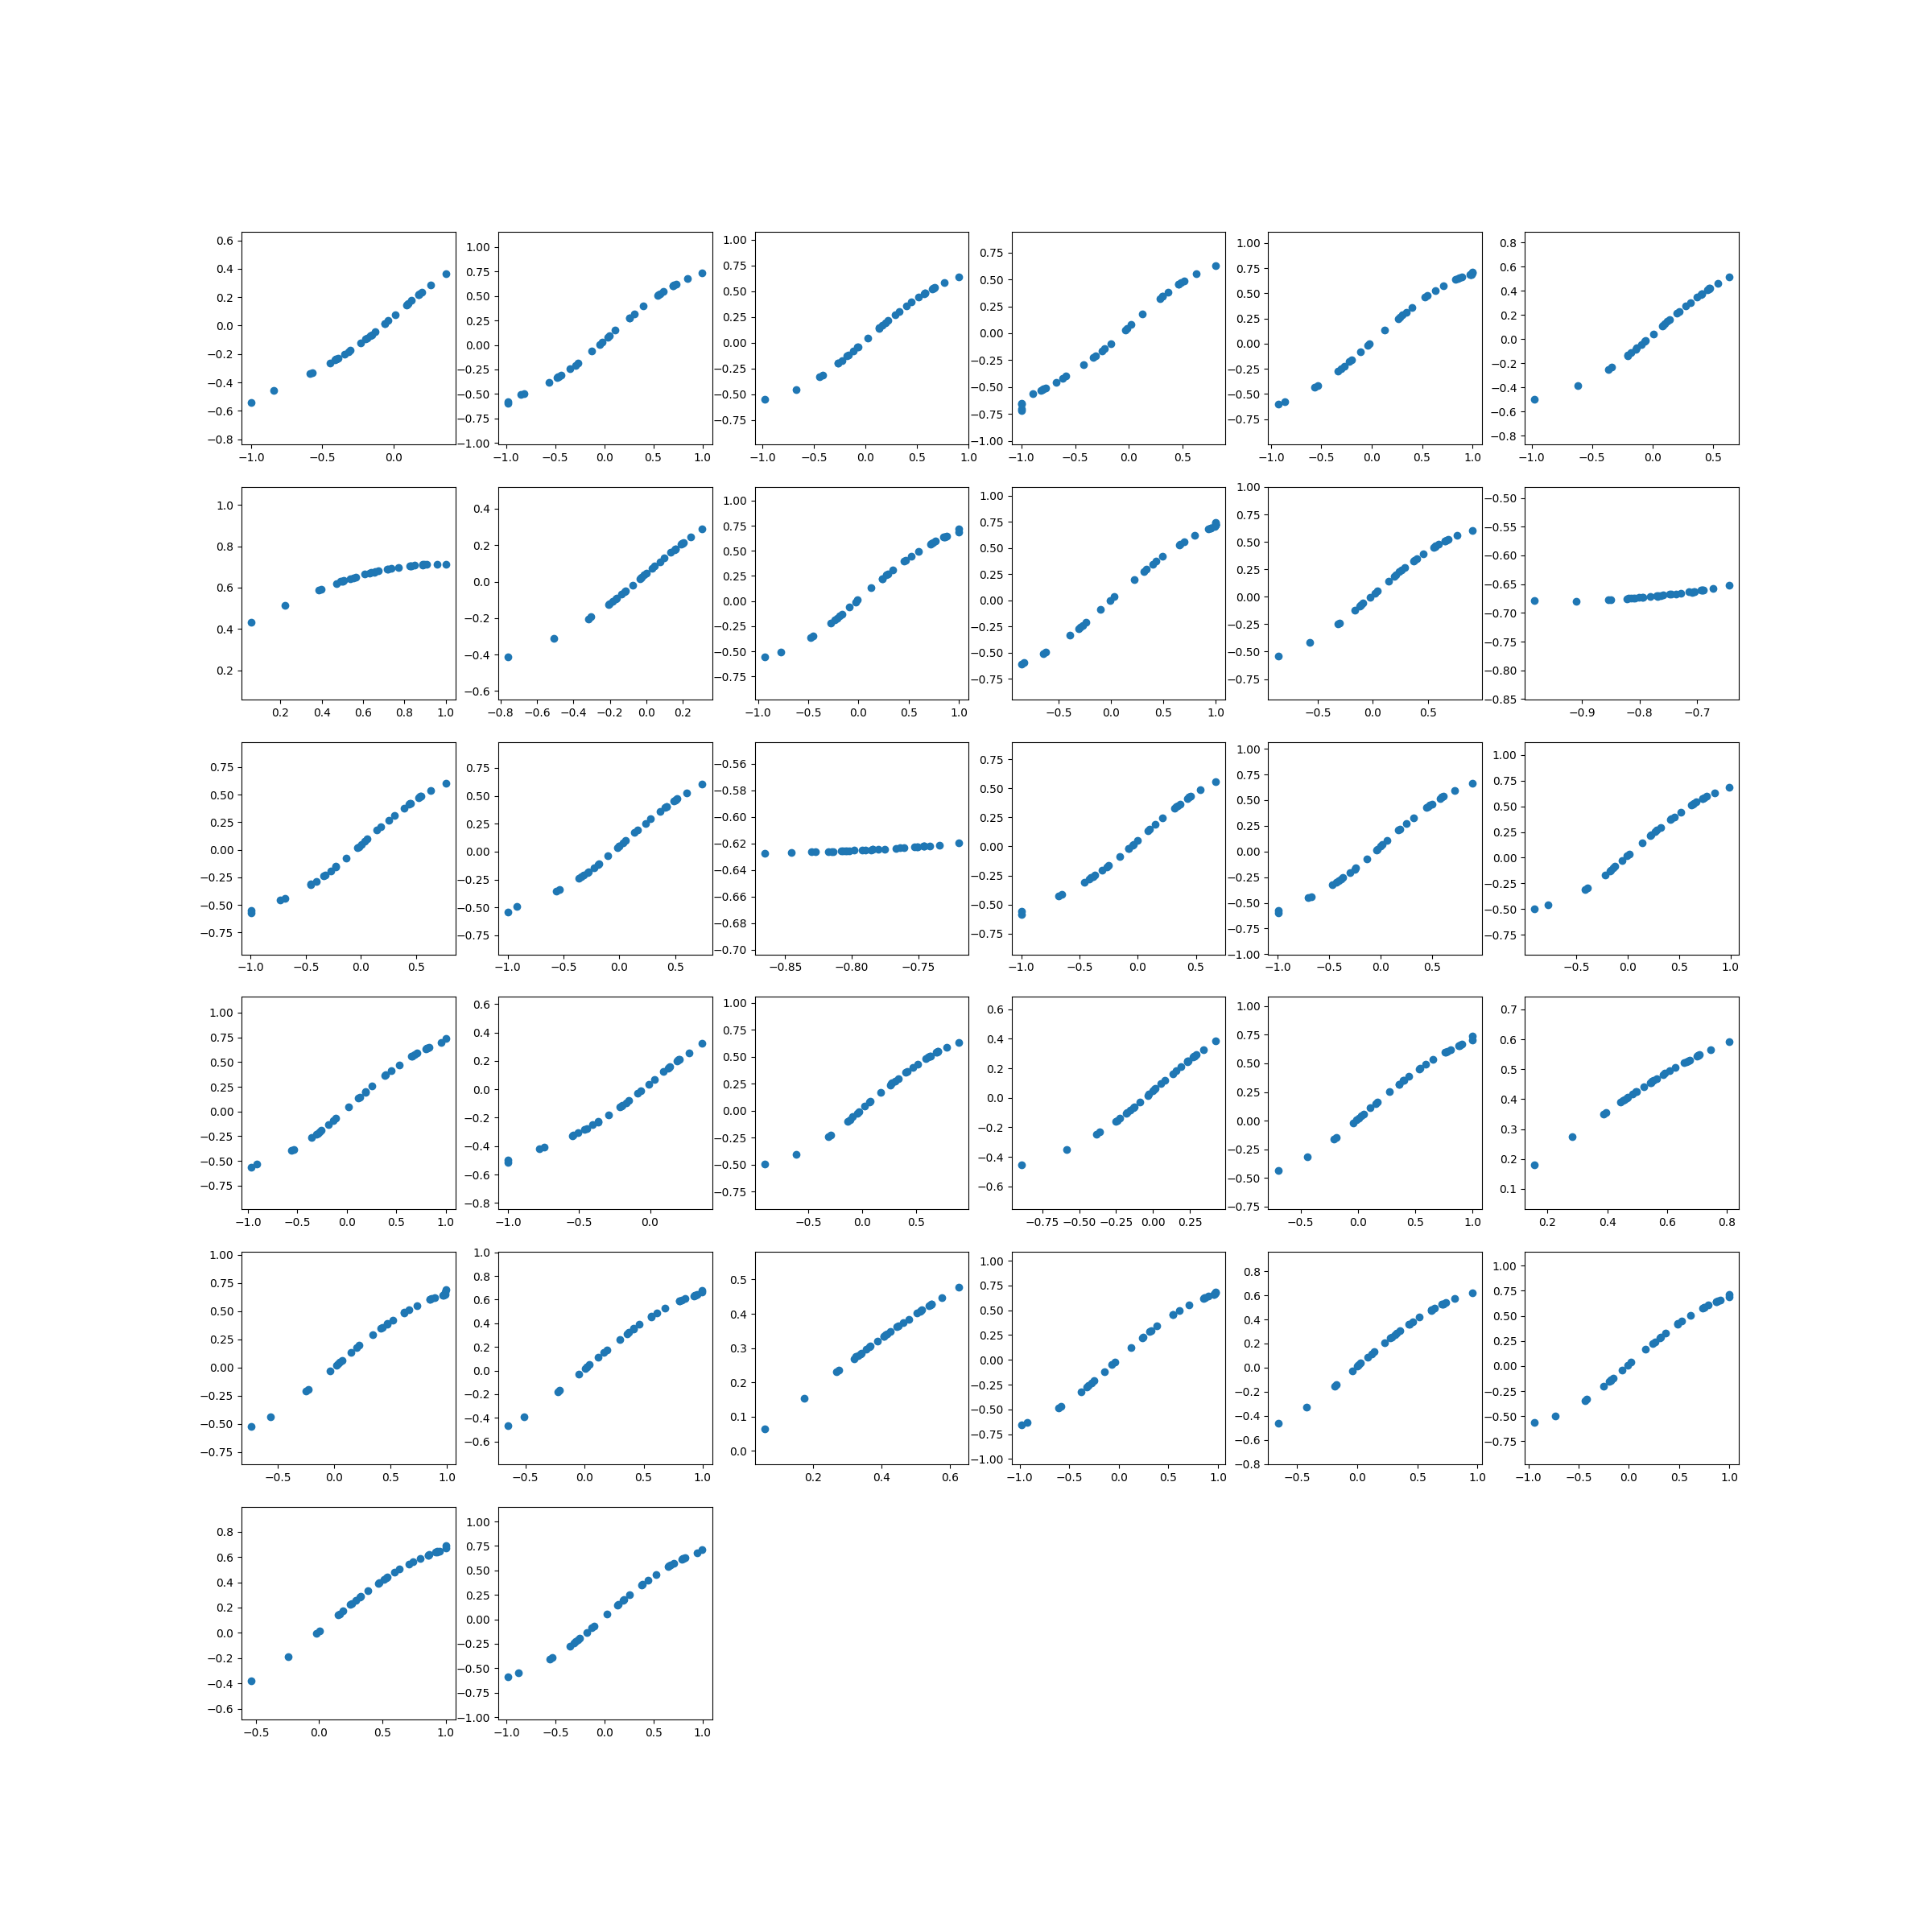

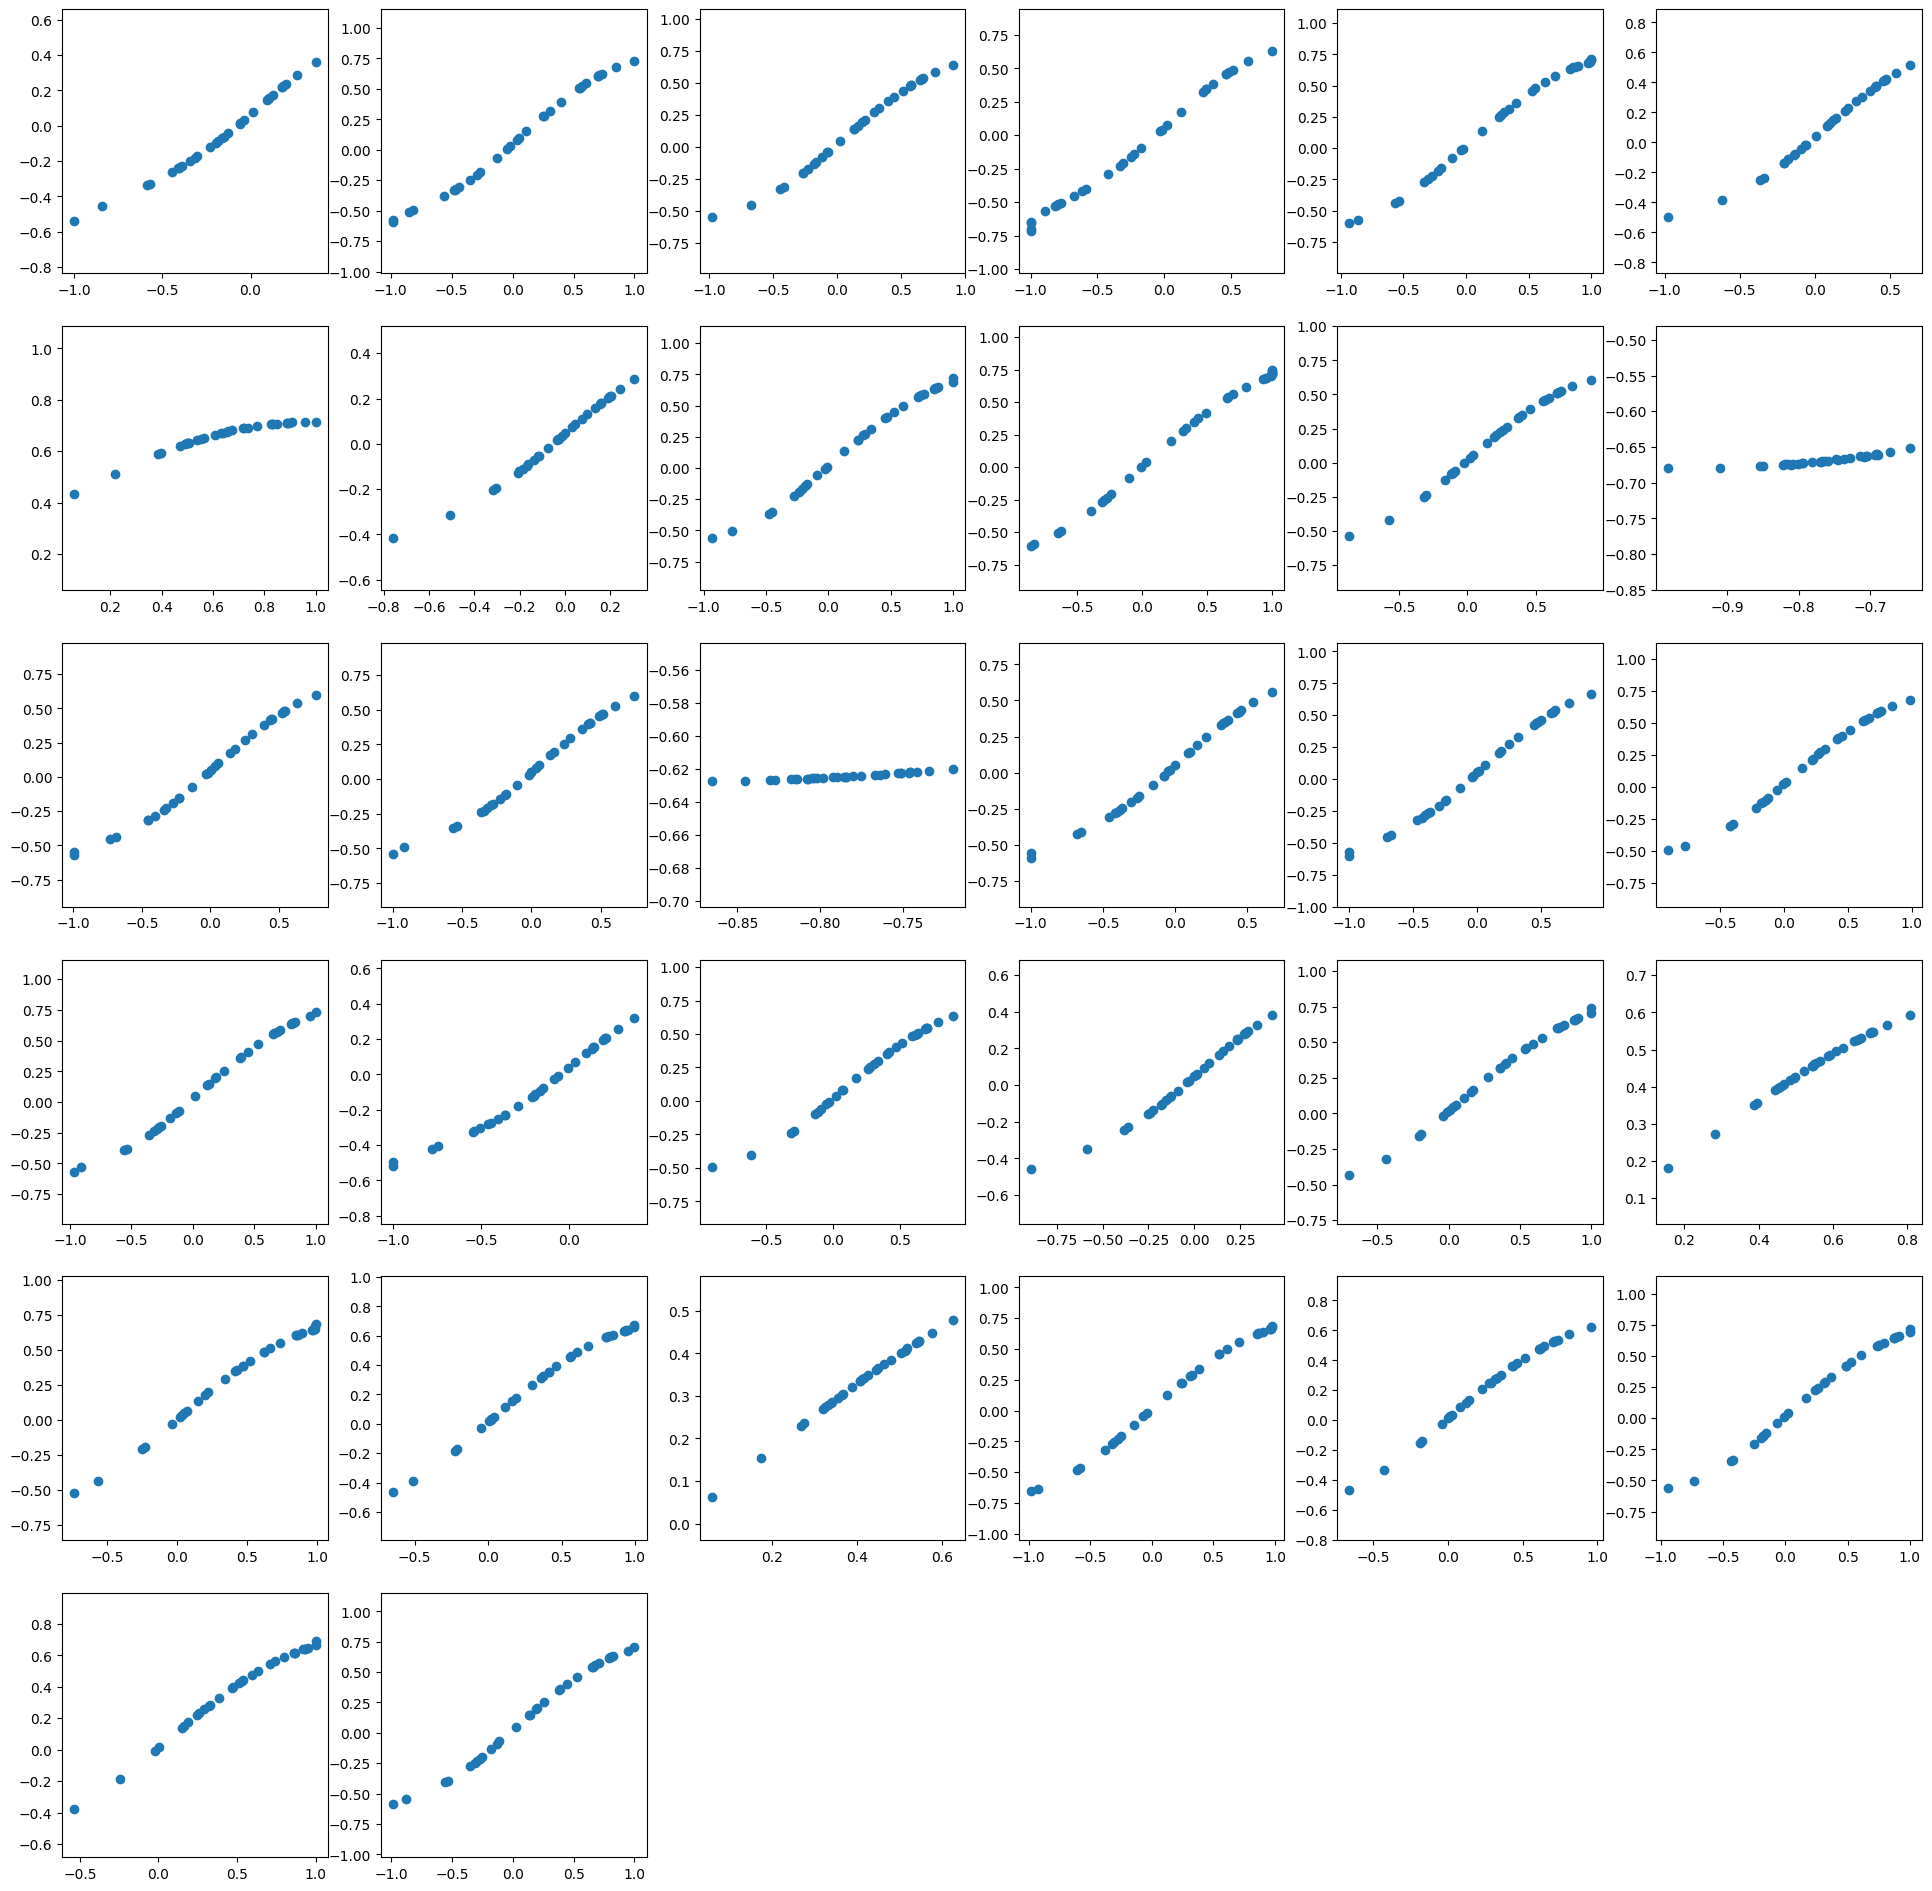

In [10]:
sample = diffusion.p_sample_loop(dit, (32, 2), clip_denoised=True)
plot_point_clouds(sample, 6, 6)